# Health Insurance Lead Prediction

__FinMan__ is a financial services company that provides various financial services like loan, investment funds, insurance etc. to its customers. FinMan wishes to cross-sell health insurance to the existing customers who may or may not hold insurance policies with the company. 

The company recommend health insurance to it's customers based on their profile once these customers land on the website. Customers might browse the recommended health insurance policy and consequently fill up a form to apply. When these customers fill-up the form, their Response towards the policy is considered positive and they are classified as a lead.

Once these leads are acquired, the sales advisors approach them to convert and thus the company can sell proposed health insurance to these leads in a more efficient manner.

I am building a model to predict whether the person will be interested in their proposed Health plan/policy given the information about:

Demographics (city, age, region etc.)
Information regarding holding policies of the customer
Recommended Policy Information

The evaluation metric for this data is __roc_auc_score__ across all entries in the test set.

### Train Data Description

ID - Unique Identifier for a row

City_Code - Code for the City of the customers

Region_Code - Code for the Region of the customers

Accomodation_Type - Customer Owns or Rents the house

Reco_Insurance_Type	- Joint or Individual type for the recommended insurance  

Upper_Age - Maximum age of the customer 

Lower _Age - Minimum age of the customer

Is_Spouse - If the customers are married to each other(in case of joint insurance)

Health_Indicator - Encoded values for health of the customer

Holding_Policy_Duration	Duration - (in years) of holding policy (a policy that customer has already subscribed to with the company)

Holding_Policy_Type - Type of holding policy

Reco_Policy_Cat	- Encoded value for recommended health insurance 

Reco_Policy_Premium	- Annual Premium (INR) for the recommended health insurance

>### Response (Target)	

0 : Customer did not show interest in the recommended policy

1 : Customer showed interest in the recommended policy

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,gc,re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score


import lightgbm as lgb
from numpy import mean
from collections import Counter
from imblearn.combine import SMOTETomek 
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

#### The warnings from Sklearn shut off #######
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
def warn(*args, **kwargs):
    pass
warnings.warn = warn

ModuleNotFoundError: No module named 'catboost'

In [ ]:
def load_data():
    train = pd.read_csv("../input/jobathon-data/train.csv")
    test  = pd.read_csv("../input/jobathon-data/test.csv")
    submission = pd.read_csv("../input/jobathon-data/sample_submission.csv")
    return train,test,submission

In [ ]:
train,_,_ = load_data()
train.head(1)

### convert data types

In [9]:
train.info()
# top 5 records

NameError: name 'train' is not defined

In [5]:
train['City_Code'] = train['City_Code'].astype('category')
train['Region_Code'] = train['Region_Code'].astype('category')
train['Accomodation_Type']=train['Accomodation_Type'].astype('category') 
train['Reco_Insurance_Type'] = train['Reco_Insurance_Type'].astype('category')
train['Reco_Policy_Cat'] = train['Reco_Policy_Cat'].astype('category')
train['Is_Spouse']=train['Is_Spouse'].astype('category')

In [6]:
train['Holding_Policy_Duration'].value_counts()

1.0     4499
14+     4335
2.0     4260
3.0     3586
4.0     2771
5.0     2362
6.0     1894
7.0     1645
8.0     1316
9.0     1114
10.0     813
11.0     546
12.0     513
13.0     511
14.0     466
Name: Holding_Policy_Duration, dtype: int64

In [7]:
train['Holding_Policy_Duration']=train['Holding_Policy_Duration'].replace('14+','15') # replace 14+ with 15
train['Holding_Policy_Duration']=train['Holding_Policy_Duration'].fillna(train['Holding_Policy_Duration'].mode()[0]) # most frequent value
train['Holding_Policy_Duration']=train['Holding_Policy_Duration'].astype('float64')
train['Holding_Policy_Duration']=train['Holding_Policy_Duration'].astype('int64')
train['Reco_Policy_Premium']=train['Reco_Policy_Premium'].astype('int64')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   ID                       50882 non-null  int64   
 1   City_Code                50882 non-null  category
 2   Region_Code              50882 non-null  category
 3   Accomodation_Type        50882 non-null  category
 4   Reco_Insurance_Type      50882 non-null  category
 5   Upper_Age                50882 non-null  int64   
 6   Lower_Age                50882 non-null  int64   
 7   Is_Spouse                50882 non-null  category
 8   Health Indicator         39191 non-null  object  
 9   Holding_Policy_Duration  50882 non-null  int64   
 10  Holding_Policy_Type      30631 non-null  float64 
 11  Reco_Policy_Cat          50882 non-null  category
 12  Reco_Policy_Premium      50882 non-null  int64   
 13  Response                 50882 non-null  int64   
dtypes: cat

### NA values

In [8]:
#  NA counts
print('Health Indicator',train['Health Indicator'].isna().sum()/train.shape[0])
print('Holding_Policy_Type',train['Holding_Policy_Type'].isna().sum()/train.shape[0])

Health Indicator 0.2297669116780001
Holding_Policy_Type 0.3979992924806415


In [9]:
## Replace NAN values with Unknown

train['Health Indicator'] = np.where(train['Health Indicator'].isnull(),"Unknown",train['Health Indicator'])
train['Health Indicator'].value_counts()
train['Health Indicator'] = train['Health Indicator'].astype('category')

In [10]:
train['Holding_Policy_Type'].value_counts()

3.0    13279
1.0     8173
2.0     5005
4.0     4174
Name: Holding_Policy_Type, dtype: int64

In [11]:
#fill NA values with most frequent

train['Holding_Policy_Type']=train['Holding_Policy_Type'].fillna(train['Holding_Policy_Type'].mode()[0]) # most frequent value
train['Holding_Policy_Type']=train['Holding_Policy_Type'].astype('int64')
train['Holding_Policy_Type']=train['Holding_Policy_Type'].astype('category')
train['Response']=train['Response'].astype('category')

In [12]:
train["Average_age"]=train[['Upper_Age','Lower_Age']].mean(axis=1)

In [8]:
train.head(1)

NameError: name 'train' is not defined

## Mutual Information

In [14]:
from sklearn.feature_selection import mutual_info_classif

In [15]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [16]:
train_data = train.copy()
train_data.drop(["ID"],axis=1,inplace=True)
y=train_data.pop('Response')
X=train_data
scores = make_mi_scores(X,y)
scores

Reco_Policy_Premium        0.075288
Region_Code                0.058714
Reco_Policy_Cat            0.023193
Lower_Age                  0.000784
Upper_Age                  0.000744
Average_age                0.000460
City_Code                  0.000294
Holding_Policy_Duration    0.000193
Health Indicator           0.000102
Reco_Insurance_Type        0.000049
Holding_Policy_Type        0.000024
Accomodation_Type          0.000014
Is_Spouse                  0.000007
Name: MI Scores, dtype: float64

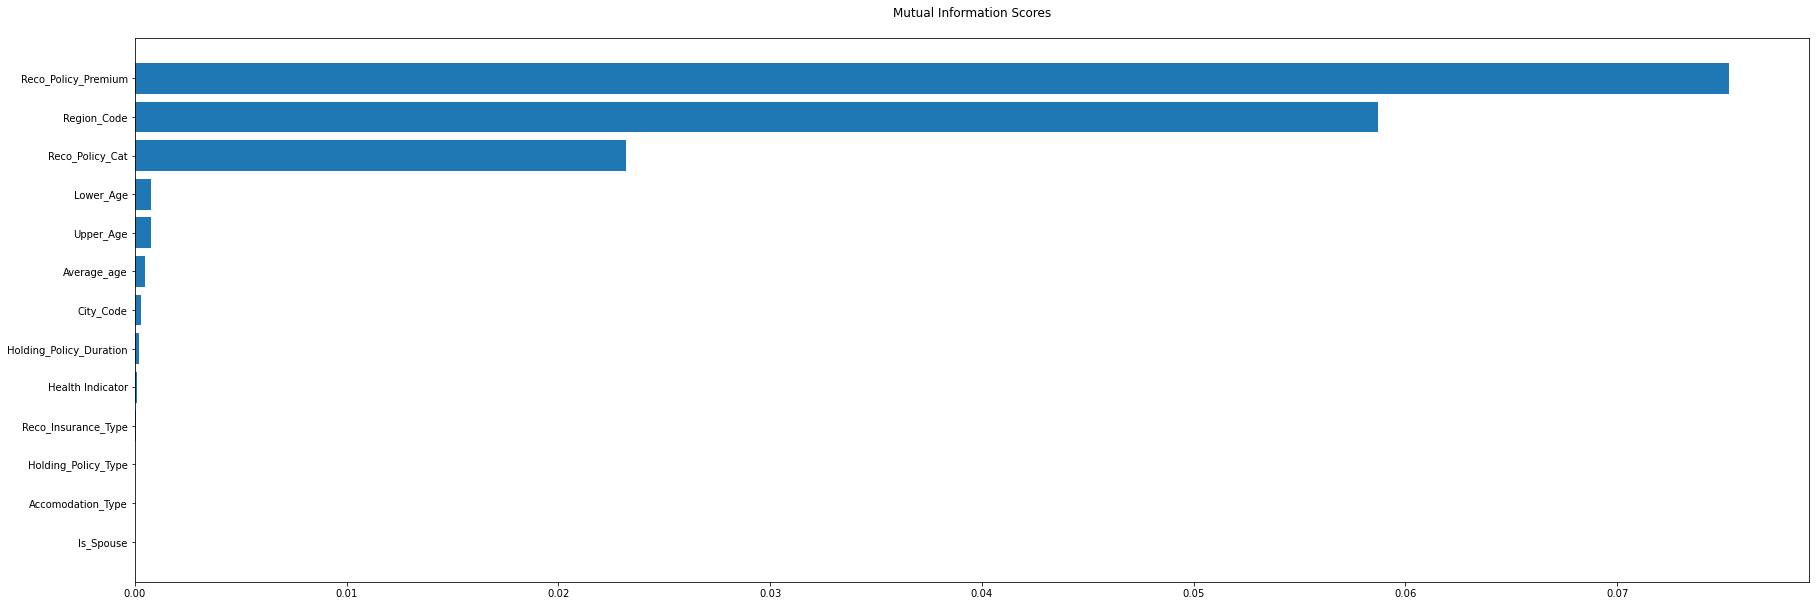

In [17]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    color = np.array(["C0"] * scores.shape[0])
    # Color red for probes
    idx = [i for i, col in enumerate(scores.index)
           if col.startswith("PROBE")]
    color[idx] = "C3"
    # Create plot
    plt.figure(figsize=(30,10))
    plt.barh(width, scores, color=color)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores\n")
    
plot_mi_scores(scores)

In [18]:
# removing least important features

train.drop(['Is_Spouse','Accomodation_Type','Holding_Policy_Type','Reco_Insurance_Type'],axis=1,inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   ID                       50882 non-null  int64   
 1   City_Code                50882 non-null  category
 2   Region_Code              50882 non-null  category
 3   Upper_Age                50882 non-null  int64   
 4   Lower_Age                50882 non-null  int64   
 5   Health Indicator         50882 non-null  category
 6   Holding_Policy_Duration  50882 non-null  int64   
 7   Reco_Policy_Cat          50882 non-null  category
 8   Reco_Policy_Premium      50882 non-null  int64   
 9   Response                 50882 non-null  category
 10  Average_age              50882 non-null  float64 
dtypes: category(5), float64(1), int64(5)
memory usage: 2.8 MB


In [19]:
# processed data set
train.to_csv("train.csv",index=False)

In [20]:
del train
gc.collect()

4005

# Model Training without Feature Engineering

I am removing the least important features step by step

In [21]:
train = pd.read_csv("train.csv")
train.drop(["ID"],axis=1,inplace=True)

for c in train.columns:
    if train[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(train[c].values))
        train[c]= le.transform(list(train[c].values))
        
train.head(1)

,City_Code,Region_Code,Upper_Age,Lower_Age,Health Indicator,Holding_Policy_Duration,Reco_Policy_Cat,Reco_Policy_Premium,Response,Average_age
0,22,3213,36,36,1,15,22,11628,0,36.0


In [22]:
scores[scores>0.00005]

Reco_Policy_Premium        0.075288
Region_Code                0.058714
Reco_Policy_Cat            0.023193
Lower_Age                  0.000784
Upper_Age                  0.000744
Average_age                0.000460
City_Code                  0.000294
Holding_Policy_Duration    0.000193
Health Indicator           0.000102
Name: MI Scores, dtype: float64

In [23]:
RANDOM_SEED = 99
target = 'Response'
preds = [x for x in list(train) if x != target]
len(preds)

9

# XGBoost Classifier

### SMOTE balance

In [24]:
from collections import Counter
from imblearn.over_sampling import SMOTE


# define dataset
X, y = train[preds],train[target]
print('Original dataset shape {}'.format(Counter(y)))


smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X_res, y_res,random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

Original dataset shape Counter({0: 38673, 1: 12209})
Resampled dataset shape Counter({0: 35381, 1: 35381})
(53071, 9) (53071,)


In [25]:
import xgboost as xgb
xgmodel = xgb.XGBClassifier(learning_rate=0.01,eval_metric='auc')

xgmodel.fit(X_train,y_train)
from sklearn.metrics import balanced_accuracy_score, accuracy_score
print('ROC_AUC:',roc_auc_score(y_test,xgmodel.predict(X_test)))

ROC_AUC: 0.6746971711055976


## RandomOverSampler

In [26]:
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
traindf,target = oversample.fit_resample(train[preds],train[target])
# summarize class distribution
counter = Counter(target)
print(counter)

Counter({0: 38673, 1: 38673})


In [27]:
X_train,X_test,y_train,y_test= train_test_split(traindf, target,random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

(58009, 9) (58009,)


In [28]:
xgmodel.fit(X_train,y_train)
print('ROC_AUC:',roc_auc_score(y_test,xgmodel.predict(X_test)))

ROC_AUC: 0.5861610862144881


In [30]:
del train,preds,xgmodel,X,y,X_train,X_test,y_train,y_test
gc.collect()

19

### SMOTE produced better result than that of RandomOverSampler

## Removing other least important features

In [31]:
train = pd.read_csv("train.csv")
train.drop(["ID",'Holding_Policy_Duration'],axis=1,inplace=True)

for c in train.columns:
    if train[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(train[c].values))
        train[c]= le.transform(list(train[c].values))
        
train.head(1)

,City_Code,Region_Code,Upper_Age,Lower_Age,Health Indicator,Reco_Policy_Cat,Reco_Policy_Premium,Response,Average_age
0,22,3213,36,36,1,22,11628,0,36.0


In [32]:
from collections import Counter
from imblearn.over_sampling import SMOTE

RANDOM_SEED = 99
target = 'Response'
preds = [x for x in list(train) if x != target]        

# define dataset
X, y = train[preds],train[target]
print('Original dataset shape {}'.format(Counter(y)))


smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X_res, y_res,random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

Original dataset shape Counter({0: 38673, 1: 12209})
Resampled dataset shape Counter({0: 35302, 1: 35302})
(52953, 8) (52953,)


In [33]:
import xgboost as xgb
xgmodel = xgb.XGBClassifier(learning_rate=0.01,eval_metric='auc')
xgmodel.fit(X_train,y_train)
from sklearn.metrics import balanced_accuracy_score, accuracy_score
print('ROC_AUC:',roc_auc_score(y_test,xgmodel.predict(X_test)))

ROC_AUC: 0.6755115774876966


In [34]:
del train,preds,xgmodel,X,y,X_train,X_test,y_train,y_test
gc.collect()

129

# Selected data set

In [35]:
train = pd.read_csv("train.csv")
train.drop(["ID",'Holding_Policy_Duration','Upper_Age','Lower_Age'],axis=1,inplace=True)
for c in train.columns:
    if train[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(train[c].values))
        train[c]= le.transform(list(train[c].values))
        
#train.to_csv('final_train.csv',index=False)
train.head(1)

,City_Code,Region_Code,Health Indicator,Reco_Policy_Cat,Reco_Policy_Premium,Response,Average_age
0,22,3213,1,22,11628,0,36.0


In [36]:
RANDOM_SEED = 99
target = 'Response'
preds = [x for x in list(train) if x != target]

# define dataset
X, y = train[preds],train[target]
print('Original dataset shape {}'.format(Counter(y)))


smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X_res, y_res,random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

Original dataset shape Counter({0: 38673, 1: 12209})
Resampled dataset shape Counter({0: 35020, 1: 35020})
(52530, 6) (52530,)


### XGBoost

In [37]:
import xgboost as xgb
xgmodel = xgb.XGBClassifier(learning_rate=0.01,eval_metric='auc')
xgmodel.fit(X_train, y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,xgmodel.predict(X_test)),6))
print("Accuracy:",round(accuracy_score(y_test,xgmodel.predict(X_test)),6))

ROC_AUC: 0.673493
Accuracy: 0.673501


### CatBoost Classifier

In [38]:
from catboost import CatBoostClassifier
RFC = CatBoostClassifier()
RFC.fit(X_train, y_train,metric_period=100)
print('ROC_AUC:',round(roc_auc_score(y_test,RFC.predict(X_test)),6))

Learning rate set to 0.055918
0:	learn: 0.6858469	total: 79ms	remaining: 1m 18s
100:	learn: 0.5694921	total: 1.6s	remaining: 14.2s
200:	learn: 0.5311860	total: 3.1s	remaining: 12.3s
300:	learn: 0.4983570	total: 4.61s	remaining: 10.7s
400:	learn: 0.4742871	total: 6.17s	remaining: 9.22s
500:	learn: 0.4559349	total: 7.71s	remaining: 7.68s
600:	learn: 0.4423569	total: 9.36s	remaining: 6.21s
700:	learn: 0.4304074	total: 10.9s	remaining: 4.66s
800:	learn: 0.4193420	total: 12.5s	remaining: 3.1s
900:	learn: 0.4098353	total: 14.1s	remaining: 1.55s
999:	learn: 0.4015583	total: 15.7s	remaining: 0us
ROC_AUC: 0.807426


## Gradient Boost Classifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
#Gradient Boosting Classifier

gb_model1 = GradientBoostingClassifier(n_estimators=500,max_depth=11)
gb_model1.fit(X_train,y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,gb_model1.predict(X_test)),6))

ROC_AUC: 0.833884


In [40]:
# selected for the final model
# train.drop(["ID",'Holding_Policy_Duration','Upper_Age','Lower_Age'],axis=1,inplace=True)

## LightGBM

In [41]:
import lightgbm as lgb
model_clf = lgb.LGBMClassifier()
model_clf.fit(X_train, y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,model_clf.predict(X_test)),6))

ROC_AUC: 0.774961


In [42]:
del train,preds,xgmodel,X,y,X_train,X_test,y_train,y_test
gc.collect()

102

### Removing Health Indicator

In [43]:
train = pd.read_csv("train.csv")
train.drop(["ID",'Holding_Policy_Duration','Health Indicator'],axis=1,inplace=True) # selected this data set

for c in train.columns:
    if train[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(train[c].values))
        train[c]= le.transform(list(train[c].values))
        
        
RANDOM_SEED = 99
target = 'Response'
preds = [x for x in list(train) if x != target]

# define dataset
X, y = train[preds],train[target]
print('Original dataset shape {}'.format(Counter(y)))


smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X_res, y_res,random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

Original dataset shape Counter({0: 38673, 1: 12209})
Resampled dataset shape Counter({0: 35283, 1: 35283})
(52924, 7) (52924,)


In [44]:
train.head(1)

,City_Code,Region_Code,Upper_Age,Lower_Age,Reco_Policy_Cat,Reco_Policy_Premium,Response,Average_age
0,22,3213,36,36,22,11628,0,36.0


## XGBoost

In [45]:
xgmodel = xgb.XGBClassifier(learning_rate=0.01,eval_metric='auc')
xgmodel.fit(X_train, y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,xgmodel.predict(X_test)),6))
print("Accuracy:",round(accuracy_score(y_test,xgmodel.predict(X_test)),6))

ROC_AUC: 0.673541
Accuracy: 0.673847


## CatBoost Classifier

In [46]:
from catboost import CatBoostClassifier
catboost = CatBoostClassifier()
catboost.fit(X_train, y_train,metric_period=100)
print('ROC_AUC:',round(roc_auc_score(y_test,catboost.predict(X_test)),6))

Learning rate set to 0.056096
0:	learn: 0.6854418	total: 17.4ms	remaining: 17.3s
100:	learn: 0.5525090	total: 1.56s	remaining: 13.9s
200:	learn: 0.5050068	total: 3.15s	remaining: 12.5s
300:	learn: 0.4724412	total: 4.74s	remaining: 11s
400:	learn: 0.4484019	total: 6.33s	remaining: 9.45s
500:	learn: 0.4304072	total: 7.92s	remaining: 7.89s
600:	learn: 0.4177328	total: 9.7s	remaining: 6.44s
700:	learn: 0.4070602	total: 11.5s	remaining: 4.92s
800:	learn: 0.3978457	total: 13.1s	remaining: 3.26s
900:	learn: 0.3897025	total: 14.7s	remaining: 1.62s
999:	learn: 0.3816908	total: 16.3s	remaining: 0us
ROC_AUC: 0.816422


In [47]:
# train.drop(["ID",'Holding_Policy_Duration','Health Indicator'],axis=1,inplace=True) 
# Catboost model with this data set is selected for hyperparameter tuning with optuna

## Gradient Boosting

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
#Gradient Boosting Classifier

gb_model2 = GradientBoostingClassifier(n_estimators=250,max_depth=10)
gb_model2.fit(X_train,y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,gb_model2.predict(X_test)),6))

ROC_AUC: 0.826078


## Light GBM


In [49]:
import lightgbm as lgb

model_clf = lgb.LGBMClassifier()
model_clf.fit(X_train, y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,model_clf.predict(X_test)),6))

ROC_AUC: 0.792808


In [50]:
# selected for the final model
# train.drop(["ID",'Holding_Policy_Duration','Health Indicator'],axis=1,inplace=True) 

In [51]:
del train,preds,xgmodel,X,y,X_train,X_test,y_train,y_test
gc.collect()

102

In [53]:
!pip install optuna -q

# Final Model

## CatBoost and Light GBM with 7 features

In [54]:
RANDOM_SEED = 99

train = pd.read_csv("train.csv")
train.drop(["ID",'Holding_Policy_Duration','Health Indicator'],axis=1,inplace=True)


for c in train.columns:
    if train[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(train[c].values))
        train[c]= le.transform(list(train[c].values))
        
target = 'Response'
preds = [x for x in list(train) if x != target]

# define dataset
X, y = train[preds],train[target]
print('Original dataset shape {}'.format(Counter(y)))


smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))
X_train,X_test,y_train,y_test= train_test_split(X_res, y_res,random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)
from catboost import CatBoostClassifier
catboost = CatBoostClassifier()
catboost.fit(X_train, y_train,metric_period=100)
print('ROC_AUC:',round(roc_auc_score(y_test,catboost.predict(X_test)),6))

Original dataset shape Counter({0: 38673, 1: 12209})
Resampled dataset shape Counter({0: 35283, 1: 35283})
(52924, 7) (52924,)
Learning rate set to 0.056096
0:	learn: 0.6854418	total: 18.2ms	remaining: 18.2s
100:	learn: 0.5525090	total: 1.6s	remaining: 14.3s
200:	learn: 0.5050068	total: 3.2s	remaining: 12.7s
300:	learn: 0.4724412	total: 4.79s	remaining: 11.1s
400:	learn: 0.4484019	total: 6.41s	remaining: 9.57s
500:	learn: 0.4304072	total: 8.1s	remaining: 8.06s
600:	learn: 0.4177328	total: 9.7s	remaining: 6.44s
700:	learn: 0.4070602	total: 11.3s	remaining: 4.82s
800:	learn: 0.3978457	total: 12.9s	remaining: 3.21s
900:	learn: 0.3897025	total: 14.6s	remaining: 1.6s
999:	learn: 0.3816908	total: 16.1s	remaining: 0us
ROC_AUC: 0.816422


In [55]:
import catboost as cb
import optuna


def objective(trial):
    data, target = X_res, y_res 
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.3)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-03-01 07:56:34,114] A new study created in memory with name: no-name-ad984b02-afc1-4b05-9b54-8dd92242e484
[I 2021-03-01 07:56:50,966] Trial 0 finished with value: 0.6274917335852621 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.038517465883885056, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.11114821936016273}. Best is trial 0 with value: 0.6274917335852621.
[I 2021-03-01 07:57:07,450] Trial 1 finished with value: 0.6351440717997165 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.04323729795645804, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7241662073599497}. Best is trial 1 with value: 0.6351440717997165.
[I 2021-03-01 07:57:15,654] Trial 2 finished with value: 0.616343882853094 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.03845550738487719, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 

[I 2021-03-01 08:01:52,251] Trial 27 finished with value: 0.6992914501653283 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08895998448476371, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 17 with value: 0.722579121398205.
[I 2021-03-01 08:02:02,866] Trial 28 finished with value: 0.7164855928200283 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09838679659144785, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 17 with value: 0.722579121398205.
[I 2021-03-01 08:02:21,469] Trial 29 finished with value: 0.6531884742560227 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.07160662383339185, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9710730487304278}. Best is trial 17 with value: 0.722579121398205.
[I 2021-03-01 08:02:31,675] Trial 30 finished with value: 0.7020784128483704 and parameters: {'objective': 'Logloss', 'colsample_byle

Number of finished trials: 53
Best trial:
  Value: 0.7304204062352385
  Params: 
    objective: Logloss
    colsample_bylevel: 0.09975688847932347
    depth: 11
    boosting_type: Plain
    bootstrap_type: MVS


In [56]:
import catboost as cb
Params = study.best_trial.params
cbopt = cb.CatBoostClassifier(**Params)
cbopt.fit(X_train, y_train,metric_period=100)
print('ROC_AUC:',round(roc_auc_score(y_test,cbopt.predict(X_test)),6))

Learning rate set to 0.056096
0:	learn: 0.6928585	total: 11ms	remaining: 11s
100:	learn: 0.6535802	total: 858ms	remaining: 7.64s
200:	learn: 0.6342793	total: 1.74s	remaining: 6.91s
300:	learn: 0.6212162	total: 2.67s	remaining: 6.19s
400:	learn: 0.6149571	total: 3.51s	remaining: 5.24s
500:	learn: 0.6081035	total: 4.31s	remaining: 4.29s
600:	learn: 0.5955903	total: 5.21s	remaining: 3.46s
700:	learn: 0.5880924	total: 6.13s	remaining: 2.61s
800:	learn: 0.5797437	total: 7.02s	remaining: 1.74s
900:	learn: 0.5715513	total: 8.16s	remaining: 896ms
999:	learn: 0.5667608	total: 9.07s	remaining: 0us
ROC_AUC: 0.705547


In [57]:
import lightgbm as lgb

model_clf = lgb.LGBMClassifier()
model_clf.fit(X_train, y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,model_clf.predict(X_test)),6))

ROC_AUC: 0.792808


## Gradient Boost with 6 features

In [58]:
RANDOM_SEED = 99
train = pd.read_csv("train.csv")
train.drop(["ID",'Holding_Policy_Duration','Upper_Age','Lower_Age'],axis=1,inplace=True)

for c in train.columns:
    if train[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(train[c].values))
        train[c]= le.transform(list(train[c].values))
        
target = 'Response'
preds = [x for x in list(train) if x != target]

# define dataset
X, y = train[preds],train[target]
print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))
X_train,X_test,y_train,y_test= train_test_split(X_res, y_res,random_state=RANDOM_SEED)
print(X_train.shape, y_train.shape)

Original dataset shape Counter({0: 38673, 1: 12209})
Resampled dataset shape Counter({0: 35020, 1: 35020})
(52530, 6) (52530,)


In [59]:
preds

['City_Code',
 'Region_Code',
 'Health Indicator',
 'Reco_Policy_Cat',
 'Reco_Policy_Premium',
 'Average_age']

In [61]:
gb_model1 = GradientBoostingClassifier(n_estimators=500,max_depth=11)
gb_model1.fit(X_train,y_train)
print('ROC_AUC:',round(roc_auc_score(y_test,gb_model1.predict(X_test)),6))

ROC_AUC: 0.833778


In [62]:
gc.collect()

52

In [63]:
from sklearn.ensemble import StackingClassifier

estimators = [('cb',catboost),('lgb',model_clf)]

clf = StackingClassifier(estimators=estimators, final_estimator= gb_model1)
clf.fit(X_train, y_train).score(X_test, y_test)

Learning rate set to 0.055918
0:	learn: 0.6858469	total: 20.7ms	remaining: 20.7s
1:	learn: 0.6795536	total: 39.3ms	remaining: 19.6s
2:	learn: 0.6730716	total: 54.6ms	remaining: 18.1s
3:	learn: 0.6674944	total: 70.2ms	remaining: 17.5s
4:	learn: 0.6625292	total: 86.6ms	remaining: 17.2s
5:	learn: 0.6590934	total: 104ms	remaining: 17.3s
6:	learn: 0.6559156	total: 121ms	remaining: 17.2s
7:	learn: 0.6533296	total: 139ms	remaining: 17.3s
8:	learn: 0.6496453	total: 157ms	remaining: 17.3s
9:	learn: 0.6469538	total: 171ms	remaining: 17s
10:	learn: 0.6448947	total: 191ms	remaining: 17.2s
11:	learn: 0.6423448	total: 213ms	remaining: 17.5s
12:	learn: 0.6403634	total: 233ms	remaining: 17.7s
13:	learn: 0.6380823	total: 252ms	remaining: 17.7s
14:	learn: 0.6363818	total: 269ms	remaining: 17.6s
15:	learn: 0.6346604	total: 285ms	remaining: 17.5s
16:	learn: 0.6323735	total: 302ms	remaining: 17.5s
17:	learn: 0.6303857	total: 318ms	remaining: 17.4s
18:	learn: 0.6286191	total: 335ms	remaining: 17.3s
19:	lear

168:	learn: 0.5439310	total: 3.15s	remaining: 15.5s
169:	learn: 0.5434347	total: 3.17s	remaining: 15.5s
170:	learn: 0.5431066	total: 3.19s	remaining: 15.4s
171:	learn: 0.5428166	total: 3.2s	remaining: 15.4s
172:	learn: 0.5424613	total: 3.22s	remaining: 15.4s
173:	learn: 0.5422692	total: 3.24s	remaining: 15.4s
174:	learn: 0.5419457	total: 3.26s	remaining: 15.4s
175:	learn: 0.5414992	total: 3.27s	remaining: 15.3s
176:	learn: 0.5411041	total: 3.29s	remaining: 15.3s
177:	learn: 0.5408764	total: 3.31s	remaining: 15.3s
178:	learn: 0.5406359	total: 3.33s	remaining: 15.3s
179:	learn: 0.5400372	total: 3.35s	remaining: 15.3s
180:	learn: 0.5395534	total: 3.36s	remaining: 15.2s
181:	learn: 0.5393081	total: 3.38s	remaining: 15.2s
182:	learn: 0.5386861	total: 3.4s	remaining: 15.2s
183:	learn: 0.5385862	total: 3.42s	remaining: 15.2s
184:	learn: 0.5383373	total: 3.44s	remaining: 15.1s
185:	learn: 0.5379904	total: 3.45s	remaining: 15.1s
186:	learn: 0.5374271	total: 3.47s	remaining: 15.1s
187:	learn: 0.

332:	learn: 0.4903943	total: 6.13s	remaining: 12.3s
333:	learn: 0.4902647	total: 6.15s	remaining: 12.3s
334:	learn: 0.4899505	total: 6.17s	remaining: 12.2s
335:	learn: 0.4894487	total: 6.18s	remaining: 12.2s
336:	learn: 0.4893147	total: 6.2s	remaining: 12.2s
337:	learn: 0.4890949	total: 6.22s	remaining: 12.2s
338:	learn: 0.4884835	total: 6.24s	remaining: 12.2s
339:	learn: 0.4881344	total: 6.26s	remaining: 12.1s
340:	learn: 0.4879852	total: 6.27s	remaining: 12.1s
341:	learn: 0.4878922	total: 6.29s	remaining: 12.1s
342:	learn: 0.4877247	total: 6.31s	remaining: 12.1s
343:	learn: 0.4875247	total: 6.33s	remaining: 12.1s
344:	learn: 0.4869888	total: 6.35s	remaining: 12.1s
345:	learn: 0.4868767	total: 6.36s	remaining: 12s
346:	learn: 0.4866540	total: 6.38s	remaining: 12s
347:	learn: 0.4865560	total: 6.4s	remaining: 12s
348:	learn: 0.4862771	total: 6.43s	remaining: 12s
349:	learn: 0.4859202	total: 6.44s	remaining: 12s
350:	learn: 0.4858022	total: 6.46s	remaining: 11.9s
351:	learn: 0.4856807	to

498:	learn: 0.4561638	total: 9.23s	remaining: 9.27s
499:	learn: 0.4560713	total: 9.25s	remaining: 9.25s
500:	learn: 0.4559349	total: 9.27s	remaining: 9.23s
501:	learn: 0.4558400	total: 9.28s	remaining: 9.21s
502:	learn: 0.4555799	total: 9.3s	remaining: 9.19s
503:	learn: 0.4555126	total: 9.32s	remaining: 9.18s
504:	learn: 0.4554460	total: 9.34s	remaining: 9.16s
505:	learn: 0.4553603	total: 9.36s	remaining: 9.14s
506:	learn: 0.4548597	total: 9.38s	remaining: 9.12s
507:	learn: 0.4547836	total: 9.39s	remaining: 9.1s
508:	learn: 0.4547042	total: 9.41s	remaining: 9.08s
509:	learn: 0.4546207	total: 9.43s	remaining: 9.06s
510:	learn: 0.4542125	total: 9.44s	remaining: 9.04s
511:	learn: 0.4541020	total: 9.46s	remaining: 9.02s
512:	learn: 0.4540435	total: 9.48s	remaining: 9s
513:	learn: 0.4539696	total: 9.5s	remaining: 8.98s
514:	learn: 0.4538603	total: 9.52s	remaining: 8.96s
515:	learn: 0.4537764	total: 9.54s	remaining: 8.94s
516:	learn: 0.4536334	total: 9.55s	remaining: 8.93s
517:	learn: 0.4535

667:	learn: 0.4343175	total: 12.4s	remaining: 6.15s
668:	learn: 0.4341751	total: 12.4s	remaining: 6.13s
669:	learn: 0.4340796	total: 12.4s	remaining: 6.11s
670:	learn: 0.4340297	total: 12.4s	remaining: 6.09s
671:	learn: 0.4339502	total: 12.4s	remaining: 6.08s
672:	learn: 0.4337378	total: 12.5s	remaining: 6.06s
673:	learn: 0.4332709	total: 12.5s	remaining: 6.04s
674:	learn: 0.4332051	total: 12.5s	remaining: 6.02s
675:	learn: 0.4331456	total: 12.5s	remaining: 6s
676:	learn: 0.4330896	total: 12.5s	remaining: 5.98s
677:	learn: 0.4330409	total: 12.6s	remaining: 5.97s
678:	learn: 0.4329854	total: 12.6s	remaining: 5.95s
679:	learn: 0.4327891	total: 12.6s	remaining: 5.93s
680:	learn: 0.4327186	total: 12.6s	remaining: 5.92s
681:	learn: 0.4324921	total: 12.7s	remaining: 5.9s
682:	learn: 0.4324113	total: 12.7s	remaining: 5.89s
683:	learn: 0.4323486	total: 12.7s	remaining: 5.87s
684:	learn: 0.4322687	total: 12.7s	remaining: 5.86s
685:	learn: 0.4321960	total: 12.8s	remaining: 5.84s
686:	learn: 0.43

829:	learn: 0.4162408	total: 15.8s	remaining: 3.23s
830:	learn: 0.4159636	total: 15.8s	remaining: 3.21s
831:	learn: 0.4158230	total: 15.8s	remaining: 3.19s
832:	learn: 0.4157797	total: 15.8s	remaining: 3.17s
833:	learn: 0.4157184	total: 15.8s	remaining: 3.15s
834:	learn: 0.4156484	total: 15.9s	remaining: 3.13s
835:	learn: 0.4156043	total: 15.9s	remaining: 3.11s
836:	learn: 0.4154820	total: 15.9s	remaining: 3.1s
837:	learn: 0.4154213	total: 15.9s	remaining: 3.08s
838:	learn: 0.4153494	total: 15.9s	remaining: 3.06s
839:	learn: 0.4152744	total: 16s	remaining: 3.04s
840:	learn: 0.4152360	total: 16s	remaining: 3.02s
841:	learn: 0.4151699	total: 16s	remaining: 3s
842:	learn: 0.4150851	total: 16s	remaining: 2.98s
843:	learn: 0.4150250	total: 16s	remaining: 2.96s
844:	learn: 0.4149796	total: 16s	remaining: 2.94s
845:	learn: 0.4149181	total: 16.1s	remaining: 2.92s
846:	learn: 0.4148345	total: 16.1s	remaining: 2.9s
847:	learn: 0.4146028	total: 16.1s	remaining: 2.88s
848:	learn: 0.4145242	total: 

990:	learn: 0.4023612	total: 18.7s	remaining: 170ms
991:	learn: 0.4022813	total: 18.7s	remaining: 151ms
992:	learn: 0.4020393	total: 18.7s	remaining: 132ms
993:	learn: 0.4019246	total: 18.8s	remaining: 113ms
994:	learn: 0.4018747	total: 18.8s	remaining: 94.3ms
995:	learn: 0.4018380	total: 18.8s	remaining: 75.5ms
996:	learn: 0.4017994	total: 18.8s	remaining: 56.6ms
997:	learn: 0.4016954	total: 18.8s	remaining: 37.7ms
998:	learn: 0.4016337	total: 18.8s	remaining: 18.9ms
999:	learn: 0.4015583	total: 18.9s	remaining: 0us
Learning rate set to 0.050836
0:	learn: 0.6864803	total: 14ms	remaining: 14s
1:	learn: 0.6806924	total: 31.4ms	remaining: 15.6s
2:	learn: 0.6747097	total: 45.1ms	remaining: 15s
3:	learn: 0.6711006	total: 60.8ms	remaining: 15.1s
4:	learn: 0.6668764	total: 73.5ms	remaining: 14.6s
5:	learn: 0.6636552	total: 86.1ms	remaining: 14.3s
6:	learn: 0.6604580	total: 102ms	remaining: 14.5s
7:	learn: 0.6566590	total: 118ms	remaining: 14.7s
8:	learn: 0.6531116	total: 135ms	remaining: 14.

158:	learn: 0.5561565	total: 2.48s	remaining: 13.1s
159:	learn: 0.5558509	total: 2.49s	remaining: 13.1s
160:	learn: 0.5556143	total: 2.5s	remaining: 13.1s
161:	learn: 0.5554235	total: 2.52s	remaining: 13s
162:	learn: 0.5552769	total: 2.54s	remaining: 13s
163:	learn: 0.5551660	total: 2.55s	remaining: 13s
164:	learn: 0.5550189	total: 2.57s	remaining: 13s
165:	learn: 0.5548780	total: 2.58s	remaining: 13s
166:	learn: 0.5543628	total: 2.6s	remaining: 13s
167:	learn: 0.5541309	total: 2.61s	remaining: 12.9s
168:	learn: 0.5535110	total: 2.63s	remaining: 12.9s
169:	learn: 0.5531934	total: 2.64s	remaining: 12.9s
170:	learn: 0.5526326	total: 2.66s	remaining: 12.9s
171:	learn: 0.5522013	total: 2.67s	remaining: 12.9s
172:	learn: 0.5519821	total: 2.69s	remaining: 12.9s
173:	learn: 0.5516497	total: 2.71s	remaining: 12.9s
174:	learn: 0.5514340	total: 2.72s	remaining: 12.8s
175:	learn: 0.5512294	total: 2.74s	remaining: 12.8s
176:	learn: 0.5510969	total: 2.76s	remaining: 12.8s
177:	learn: 0.5508021	tota

327:	learn: 0.5037402	total: 5.16s	remaining: 10.6s
328:	learn: 0.5033805	total: 5.18s	remaining: 10.6s
329:	learn: 0.5029339	total: 5.2s	remaining: 10.5s
330:	learn: 0.5023544	total: 5.21s	remaining: 10.5s
331:	learn: 0.5020907	total: 5.23s	remaining: 10.5s
332:	learn: 0.5019640	total: 5.24s	remaining: 10.5s
333:	learn: 0.5018566	total: 5.26s	remaining: 10.5s
334:	learn: 0.5013452	total: 5.28s	remaining: 10.5s
335:	learn: 0.5011473	total: 5.29s	remaining: 10.5s
336:	learn: 0.5009989	total: 5.3s	remaining: 10.4s
337:	learn: 0.5008806	total: 5.32s	remaining: 10.4s
338:	learn: 0.5006125	total: 5.33s	remaining: 10.4s
339:	learn: 0.5001236	total: 5.35s	remaining: 10.4s
340:	learn: 0.4999799	total: 5.37s	remaining: 10.4s
341:	learn: 0.4998511	total: 5.38s	remaining: 10.4s
342:	learn: 0.4996755	total: 5.4s	remaining: 10.3s
343:	learn: 0.4994998	total: 5.41s	remaining: 10.3s
344:	learn: 0.4992178	total: 5.43s	remaining: 10.3s
345:	learn: 0.4990791	total: 5.45s	remaining: 10.3s
346:	learn: 0.4

497:	learn: 0.4698469	total: 7.86s	remaining: 7.92s
498:	learn: 0.4696969	total: 7.87s	remaining: 7.91s
499:	learn: 0.4695839	total: 7.89s	remaining: 7.89s
500:	learn: 0.4694732	total: 7.91s	remaining: 7.88s
501:	learn: 0.4688890	total: 7.92s	remaining: 7.86s
502:	learn: 0.4687756	total: 7.93s	remaining: 7.84s
503:	learn: 0.4687008	total: 7.95s	remaining: 7.83s
504:	learn: 0.4685563	total: 7.97s	remaining: 7.81s
505:	learn: 0.4682568	total: 7.99s	remaining: 7.8s
506:	learn: 0.4679841	total: 8s	remaining: 7.78s
507:	learn: 0.4678862	total: 8.02s	remaining: 7.76s
508:	learn: 0.4678116	total: 8.03s	remaining: 7.75s
509:	learn: 0.4675926	total: 8.05s	remaining: 7.73s
510:	learn: 0.4675145	total: 8.07s	remaining: 7.72s
511:	learn: 0.4673967	total: 8.08s	remaining: 7.7s
512:	learn: 0.4673124	total: 8.1s	remaining: 7.69s
513:	learn: 0.4671759	total: 8.11s	remaining: 7.67s
514:	learn: 0.4670915	total: 8.13s	remaining: 7.66s
515:	learn: 0.4669890	total: 8.14s	remaining: 7.64s
516:	learn: 0.4668

666:	learn: 0.4460862	total: 10.5s	remaining: 5.26s
667:	learn: 0.4460006	total: 10.6s	remaining: 5.25s
668:	learn: 0.4459330	total: 10.6s	remaining: 5.23s
669:	learn: 0.4458603	total: 10.6s	remaining: 5.21s
670:	learn: 0.4455715	total: 10.6s	remaining: 5.2s
671:	learn: 0.4454471	total: 10.6s	remaining: 5.18s
672:	learn: 0.4452466	total: 10.6s	remaining: 5.17s
673:	learn: 0.4451477	total: 10.6s	remaining: 5.15s
674:	learn: 0.4449493	total: 10.7s	remaining: 5.13s
675:	learn: 0.4447126	total: 10.7s	remaining: 5.12s
676:	learn: 0.4445078	total: 10.7s	remaining: 5.1s
677:	learn: 0.4444475	total: 10.7s	remaining: 5.09s
678:	learn: 0.4443698	total: 10.7s	remaining: 5.07s
679:	learn: 0.4442530	total: 10.7s	remaining: 5.06s
680:	learn: 0.4441495	total: 10.8s	remaining: 5.04s
681:	learn: 0.4440746	total: 10.8s	remaining: 5.02s
682:	learn: 0.4440067	total: 10.8s	remaining: 5.01s
683:	learn: 0.4439222	total: 10.8s	remaining: 4.99s
684:	learn: 0.4438024	total: 10.8s	remaining: 4.98s
685:	learn: 0.

836:	learn: 0.4259346	total: 13.3s	remaining: 2.58s
837:	learn: 0.4258677	total: 13.3s	remaining: 2.57s
838:	learn: 0.4258023	total: 13.3s	remaining: 2.55s
839:	learn: 0.4257016	total: 13.3s	remaining: 2.54s
840:	learn: 0.4255382	total: 13.3s	remaining: 2.52s
841:	learn: 0.4253922	total: 13.3s	remaining: 2.5s
842:	learn: 0.4253432	total: 13.4s	remaining: 2.49s
843:	learn: 0.4252666	total: 13.4s	remaining: 2.47s
844:	learn: 0.4251967	total: 13.4s	remaining: 2.46s
845:	learn: 0.4251025	total: 13.4s	remaining: 2.44s
846:	learn: 0.4249916	total: 13.4s	remaining: 2.42s
847:	learn: 0.4249481	total: 13.4s	remaining: 2.41s
848:	learn: 0.4246320	total: 13.5s	remaining: 2.39s
849:	learn: 0.4245574	total: 13.5s	remaining: 2.38s
850:	learn: 0.4244795	total: 13.5s	remaining: 2.36s
851:	learn: 0.4244164	total: 13.5s	remaining: 2.35s
852:	learn: 0.4243404	total: 13.5s	remaining: 2.33s
853:	learn: 0.4242317	total: 13.5s	remaining: 2.31s
854:	learn: 0.4239834	total: 13.6s	remaining: 2.3s
855:	learn: 0.

Learning rate set to 0.050836
0:	learn: 0.6863646	total: 15.4ms	remaining: 15.4s
1:	learn: 0.6804000	total: 32ms	remaining: 15.9s
2:	learn: 0.6742868	total: 44.7ms	remaining: 14.8s
3:	learn: 0.6706650	total: 61.5ms	remaining: 15.3s
4:	learn: 0.6663255	total: 74.7ms	remaining: 14.9s
5:	learn: 0.6628348	total: 90.3ms	remaining: 15s
6:	learn: 0.6589398	total: 107ms	remaining: 15.1s
7:	learn: 0.6551597	total: 121ms	remaining: 15s
8:	learn: 0.6514962	total: 134ms	remaining: 14.7s
9:	learn: 0.6484663	total: 149ms	remaining: 14.8s
10:	learn: 0.6459848	total: 165ms	remaining: 14.8s
11:	learn: 0.6433155	total: 180ms	remaining: 14.8s
12:	learn: 0.6411370	total: 194ms	remaining: 14.7s
13:	learn: 0.6389808	total: 210ms	remaining: 14.8s
14:	learn: 0.6370818	total: 224ms	remaining: 14.7s
15:	learn: 0.6359928	total: 239ms	remaining: 14.7s
16:	learn: 0.6345609	total: 254ms	remaining: 14.7s
17:	learn: 0.6329786	total: 269ms	remaining: 14.7s
18:	learn: 0.6313305	total: 283ms	remaining: 14.6s
19:	learn: 

170:	learn: 0.5489745	total: 2.68s	remaining: 13s
171:	learn: 0.5484916	total: 2.69s	remaining: 13s
172:	learn: 0.5482972	total: 2.71s	remaining: 13s
173:	learn: 0.5480775	total: 2.72s	remaining: 12.9s
174:	learn: 0.5477099	total: 2.74s	remaining: 12.9s
175:	learn: 0.5471341	total: 2.75s	remaining: 12.9s
176:	learn: 0.5469697	total: 2.77s	remaining: 12.9s
177:	learn: 0.5467518	total: 2.78s	remaining: 12.9s
178:	learn: 0.5463778	total: 2.8s	remaining: 12.8s
179:	learn: 0.5459094	total: 2.81s	remaining: 12.8s
180:	learn: 0.5454938	total: 2.83s	remaining: 12.8s
181:	learn: 0.5452881	total: 2.84s	remaining: 12.8s
182:	learn: 0.5449383	total: 2.86s	remaining: 12.8s
183:	learn: 0.5446356	total: 2.88s	remaining: 12.8s
184:	learn: 0.5442395	total: 2.89s	remaining: 12.7s
185:	learn: 0.5440554	total: 2.91s	remaining: 12.7s
186:	learn: 0.5439489	total: 2.92s	remaining: 12.7s
187:	learn: 0.5435613	total: 2.94s	remaining: 12.7s
188:	learn: 0.5433139	total: 2.96s	remaining: 12.7s
189:	learn: 0.54295

332:	learn: 0.4974900	total: 5.18s	remaining: 10.4s
333:	learn: 0.4973611	total: 5.2s	remaining: 10.4s
334:	learn: 0.4972368	total: 5.21s	remaining: 10.3s
335:	learn: 0.4968283	total: 5.22s	remaining: 10.3s
336:	learn: 0.4965404	total: 5.24s	remaining: 10.3s
337:	learn: 0.4964215	total: 5.25s	remaining: 10.3s
338:	learn: 0.4963191	total: 5.27s	remaining: 10.3s
339:	learn: 0.4961429	total: 5.29s	remaining: 10.3s
340:	learn: 0.4959010	total: 5.3s	remaining: 10.3s
341:	learn: 0.4957908	total: 5.32s	remaining: 10.2s
342:	learn: 0.4956561	total: 5.34s	remaining: 10.2s
343:	learn: 0.4954551	total: 5.35s	remaining: 10.2s
344:	learn: 0.4953102	total: 5.37s	remaining: 10.2s
345:	learn: 0.4948004	total: 5.38s	remaining: 10.2s
346:	learn: 0.4946186	total: 5.4s	remaining: 10.2s
347:	learn: 0.4941934	total: 5.41s	remaining: 10.1s
348:	learn: 0.4940161	total: 5.43s	remaining: 10.1s
349:	learn: 0.4935294	total: 5.44s	remaining: 10.1s
350:	learn: 0.4932573	total: 5.46s	remaining: 10.1s
351:	learn: 0.4

504:	learn: 0.4666612	total: 7.87s	remaining: 7.72s
505:	learn: 0.4665635	total: 7.89s	remaining: 7.7s
506:	learn: 0.4664648	total: 7.9s	remaining: 7.68s
507:	learn: 0.4663531	total: 7.92s	remaining: 7.67s
508:	learn: 0.4662459	total: 7.93s	remaining: 7.65s
509:	learn: 0.4661765	total: 7.95s	remaining: 7.64s
510:	learn: 0.4660566	total: 7.97s	remaining: 7.62s
511:	learn: 0.4659358	total: 7.98s	remaining: 7.61s
512:	learn: 0.4658317	total: 8s	remaining: 7.59s
513:	learn: 0.4653920	total: 8.01s	remaining: 7.58s
514:	learn: 0.4652285	total: 8.03s	remaining: 7.56s
515:	learn: 0.4648796	total: 8.04s	remaining: 7.55s
516:	learn: 0.4647894	total: 8.06s	remaining: 7.53s
517:	learn: 0.4647083	total: 8.08s	remaining: 7.52s
518:	learn: 0.4646241	total: 8.09s	remaining: 7.5s
519:	learn: 0.4645444	total: 8.11s	remaining: 7.49s
520:	learn: 0.4642901	total: 8.13s	remaining: 7.47s
521:	learn: 0.4641712	total: 8.14s	remaining: 7.46s
522:	learn: 0.4639628	total: 8.16s	remaining: 7.44s
523:	learn: 0.4638

667:	learn: 0.4434709	total: 10.9s	remaining: 5.4s
668:	learn: 0.4434275	total: 10.9s	remaining: 5.38s
669:	learn: 0.4433461	total: 10.9s	remaining: 5.37s
670:	learn: 0.4432748	total: 10.9s	remaining: 5.35s
671:	learn: 0.4430062	total: 10.9s	remaining: 5.34s
672:	learn: 0.4428479	total: 11s	remaining: 5.32s
673:	learn: 0.4427227	total: 11s	remaining: 5.31s
674:	learn: 0.4426339	total: 11s	remaining: 5.29s
675:	learn: 0.4425202	total: 11s	remaining: 5.27s
676:	learn: 0.4423794	total: 11s	remaining: 5.26s
677:	learn: 0.4423072	total: 11s	remaining: 5.24s
678:	learn: 0.4422249	total: 11.1s	remaining: 5.22s
679:	learn: 0.4421525	total: 11.1s	remaining: 5.21s
680:	learn: 0.4420808	total: 11.1s	remaining: 5.19s
681:	learn: 0.4420205	total: 11.1s	remaining: 5.18s
682:	learn: 0.4419333	total: 11.1s	remaining: 5.16s
683:	learn: 0.4417155	total: 11.1s	remaining: 5.14s
684:	learn: 0.4416250	total: 11.1s	remaining: 5.13s
685:	learn: 0.4414424	total: 11.2s	remaining: 5.11s
686:	learn: 0.4413479	tot

834:	learn: 0.4235195	total: 13.5s	remaining: 2.68s
835:	learn: 0.4231816	total: 13.6s	remaining: 2.66s
836:	learn: 0.4230958	total: 13.6s	remaining: 2.64s
837:	learn: 0.4230433	total: 13.6s	remaining: 2.63s
838:	learn: 0.4229525	total: 13.6s	remaining: 2.61s
839:	learn: 0.4227973	total: 13.6s	remaining: 2.6s
840:	learn: 0.4227360	total: 13.6s	remaining: 2.58s
841:	learn: 0.4225507	total: 13.7s	remaining: 2.56s
842:	learn: 0.4224921	total: 13.7s	remaining: 2.54s
843:	learn: 0.4224040	total: 13.7s	remaining: 2.53s
844:	learn: 0.4222510	total: 13.7s	remaining: 2.51s
845:	learn: 0.4220016	total: 13.7s	remaining: 2.5s
846:	learn: 0.4219367	total: 13.7s	remaining: 2.48s
847:	learn: 0.4217805	total: 13.8s	remaining: 2.46s
848:	learn: 0.4215995	total: 13.8s	remaining: 2.45s
849:	learn: 0.4215189	total: 13.8s	remaining: 2.43s
850:	learn: 0.4214795	total: 13.8s	remaining: 2.42s
851:	learn: 0.4212571	total: 13.8s	remaining: 2.4s
852:	learn: 0.4211883	total: 13.8s	remaining: 2.38s
853:	learn: 0.4

Learning rate set to 0.050836
0:	learn: 0.6866391	total: 13.7ms	remaining: 13.7s
1:	learn: 0.6801101	total: 28ms	remaining: 14s
2:	learn: 0.6748171	total: 45.4ms	remaining: 15.1s
3:	learn: 0.6704480	total: 57.8ms	remaining: 14.4s
4:	learn: 0.6657992	total: 73.9ms	remaining: 14.7s
5:	learn: 0.6629987	total: 91.1ms	remaining: 15.1s
6:	learn: 0.6594752	total: 106ms	remaining: 15s
7:	learn: 0.6559240	total: 120ms	remaining: 14.9s
8:	learn: 0.6536665	total: 138ms	remaining: 15.2s
9:	learn: 0.6508452	total: 153ms	remaining: 15.2s
10:	learn: 0.6480412	total: 169ms	remaining: 15.2s
11:	learn: 0.6455099	total: 184ms	remaining: 15.1s
12:	learn: 0.6435716	total: 204ms	remaining: 15.5s
13:	learn: 0.6417682	total: 218ms	remaining: 15.4s
14:	learn: 0.6404851	total: 234ms	remaining: 15.4s
15:	learn: 0.6387734	total: 250ms	remaining: 15.4s
16:	learn: 0.6372319	total: 267ms	remaining: 15.4s
17:	learn: 0.6353109	total: 283ms	remaining: 15.4s
18:	learn: 0.6334089	total: 297ms	remaining: 15.3s
19:	learn: 

168:	learn: 0.5525267	total: 2.71s	remaining: 13.3s
169:	learn: 0.5520633	total: 2.72s	remaining: 13.3s
170:	learn: 0.5519376	total: 2.74s	remaining: 13.3s
171:	learn: 0.5517610	total: 2.75s	remaining: 13.3s
172:	learn: 0.5515316	total: 2.77s	remaining: 13.2s
173:	learn: 0.5513651	total: 2.78s	remaining: 13.2s
174:	learn: 0.5509833	total: 2.79s	remaining: 13.2s
175:	learn: 0.5507038	total: 2.81s	remaining: 13.2s
176:	learn: 0.5505123	total: 2.83s	remaining: 13.1s
177:	learn: 0.5502434	total: 2.84s	remaining: 13.1s
178:	learn: 0.5497101	total: 2.86s	remaining: 13.1s
179:	learn: 0.5495497	total: 2.87s	remaining: 13.1s
180:	learn: 0.5494095	total: 2.89s	remaining: 13.1s
181:	learn: 0.5491757	total: 2.9s	remaining: 13.1s
182:	learn: 0.5490783	total: 2.92s	remaining: 13s
183:	learn: 0.5488632	total: 2.94s	remaining: 13s
184:	learn: 0.5486382	total: 2.96s	remaining: 13s
185:	learn: 0.5483265	total: 2.97s	remaining: 13s
186:	learn: 0.5481388	total: 2.99s	remaining: 13s
187:	learn: 0.5477044	t

337:	learn: 0.5008806	total: 5.41s	remaining: 10.6s
338:	learn: 0.5007384	total: 5.43s	remaining: 10.6s
339:	learn: 0.5005004	total: 5.44s	remaining: 10.6s
340:	learn: 0.4999748	total: 5.46s	remaining: 10.5s
341:	learn: 0.4998769	total: 5.47s	remaining: 10.5s
342:	learn: 0.4991786	total: 5.49s	remaining: 10.5s
343:	learn: 0.4989339	total: 5.51s	remaining: 10.5s
344:	learn: 0.4987879	total: 5.52s	remaining: 10.5s
345:	learn: 0.4983077	total: 5.54s	remaining: 10.5s
346:	learn: 0.4980026	total: 5.55s	remaining: 10.5s
347:	learn: 0.4978367	total: 5.57s	remaining: 10.4s
348:	learn: 0.4976546	total: 5.59s	remaining: 10.4s
349:	learn: 0.4975305	total: 5.6s	remaining: 10.4s
350:	learn: 0.4970403	total: 5.62s	remaining: 10.4s
351:	learn: 0.4968487	total: 5.64s	remaining: 10.4s
352:	learn: 0.4966853	total: 5.65s	remaining: 10.4s
353:	learn: 0.4965785	total: 5.67s	remaining: 10.3s
354:	learn: 0.4964786	total: 5.68s	remaining: 10.3s
355:	learn: 0.4962614	total: 5.7s	remaining: 10.3s
356:	learn: 0.

508:	learn: 0.4655863	total: 8.13s	remaining: 7.84s
509:	learn: 0.4654191	total: 8.14s	remaining: 7.82s
510:	learn: 0.4652176	total: 8.16s	remaining: 7.8s
511:	learn: 0.4649796	total: 8.17s	remaining: 7.79s
512:	learn: 0.4647916	total: 8.19s	remaining: 7.77s
513:	learn: 0.4647270	total: 8.2s	remaining: 7.75s
514:	learn: 0.4646605	total: 8.22s	remaining: 7.74s
515:	learn: 0.4645251	total: 8.23s	remaining: 7.72s
516:	learn: 0.4641904	total: 8.25s	remaining: 7.71s
517:	learn: 0.4640149	total: 8.27s	remaining: 7.69s
518:	learn: 0.4639364	total: 8.28s	remaining: 7.67s
519:	learn: 0.4637336	total: 8.3s	remaining: 7.66s
520:	learn: 0.4636273	total: 8.31s	remaining: 7.64s
521:	learn: 0.4633500	total: 8.33s	remaining: 7.63s
522:	learn: 0.4632252	total: 8.35s	remaining: 7.61s
523:	learn: 0.4631457	total: 8.36s	remaining: 7.59s
524:	learn: 0.4630508	total: 8.38s	remaining: 7.58s
525:	learn: 0.4627632	total: 8.39s	remaining: 7.56s
526:	learn: 0.4625142	total: 8.41s	remaining: 7.54s
527:	learn: 0.4

675:	learn: 0.4401614	total: 10.8s	remaining: 5.19s
676:	learn: 0.4400718	total: 10.8s	remaining: 5.17s
677:	learn: 0.4399833	total: 10.9s	remaining: 5.16s
678:	learn: 0.4398798	total: 10.9s	remaining: 5.14s
679:	learn: 0.4398117	total: 10.9s	remaining: 5.13s
680:	learn: 0.4397502	total: 10.9s	remaining: 5.11s
681:	learn: 0.4394755	total: 10.9s	remaining: 5.09s
682:	learn: 0.4393852	total: 10.9s	remaining: 5.08s
683:	learn: 0.4392570	total: 11s	remaining: 5.06s
684:	learn: 0.4391625	total: 11s	remaining: 5.05s
685:	learn: 0.4390347	total: 11s	remaining: 5.03s
686:	learn: 0.4387718	total: 11s	remaining: 5.01s
687:	learn: 0.4385465	total: 11s	remaining: 5s
688:	learn: 0.4384079	total: 11s	remaining: 4.98s
689:	learn: 0.4383569	total: 11.1s	remaining: 4.97s
690:	learn: 0.4382836	total: 11.1s	remaining: 4.95s
691:	learn: 0.4379111	total: 11.1s	remaining: 4.93s
692:	learn: 0.4378310	total: 11.1s	remaining: 4.92s
693:	learn: 0.4377745	total: 11.1s	remaining: 4.9s
694:	learn: 0.4375780	total:

843:	learn: 0.4219375	total: 13.5s	remaining: 2.5s
844:	learn: 0.4218479	total: 13.5s	remaining: 2.48s
845:	learn: 0.4217906	total: 13.6s	remaining: 2.47s
846:	learn: 0.4217312	total: 13.6s	remaining: 2.45s
847:	learn: 0.4216730	total: 13.6s	remaining: 2.43s
848:	learn: 0.4215542	total: 13.6s	remaining: 2.42s
849:	learn: 0.4214897	total: 13.6s	remaining: 2.4s
850:	learn: 0.4214113	total: 13.6s	remaining: 2.39s
851:	learn: 0.4213347	total: 13.6s	remaining: 2.37s
852:	learn: 0.4211607	total: 13.7s	remaining: 2.35s
853:	learn: 0.4211060	total: 13.7s	remaining: 2.34s
854:	learn: 0.4210088	total: 13.7s	remaining: 2.32s
855:	learn: 0.4209083	total: 13.7s	remaining: 2.31s
856:	learn: 0.4208534	total: 13.7s	remaining: 2.29s
857:	learn: 0.4207230	total: 13.7s	remaining: 2.27s
858:	learn: 0.4206533	total: 13.8s	remaining: 2.26s
859:	learn: 0.4205555	total: 13.8s	remaining: 2.24s
860:	learn: 0.4204914	total: 13.8s	remaining: 2.23s
861:	learn: 0.4203198	total: 13.8s	remaining: 2.21s
862:	learn: 0.

11:	learn: 0.6436067	total: 198ms	remaining: 16.3s
12:	learn: 0.6416215	total: 213ms	remaining: 16.1s
13:	learn: 0.6400630	total: 230ms	remaining: 16.2s
14:	learn: 0.6380619	total: 247ms	remaining: 16.2s
15:	learn: 0.6360301	total: 263ms	remaining: 16.2s
16:	learn: 0.6341810	total: 280ms	remaining: 16.2s
17:	learn: 0.6329598	total: 298ms	remaining: 16.3s
18:	learn: 0.6318213	total: 317ms	remaining: 16.4s
19:	learn: 0.6303735	total: 334ms	remaining: 16.4s
20:	learn: 0.6286196	total: 349ms	remaining: 16.3s
21:	learn: 0.6264789	total: 366ms	remaining: 16.3s
22:	learn: 0.6247656	total: 384ms	remaining: 16.3s
23:	learn: 0.6236539	total: 402ms	remaining: 16.3s
24:	learn: 0.6225627	total: 417ms	remaining: 16.3s
25:	learn: 0.6210908	total: 430ms	remaining: 16.1s
26:	learn: 0.6200081	total: 447ms	remaining: 16.1s
27:	learn: 0.6191313	total: 463ms	remaining: 16.1s
28:	learn: 0.6180898	total: 479ms	remaining: 16s
29:	learn: 0.6168136	total: 496ms	remaining: 16.1s
30:	learn: 0.6153836	total: 513ms

178:	learn: 0.5465946	total: 2.88s	remaining: 13.2s
179:	learn: 0.5460610	total: 2.9s	remaining: 13.2s
180:	learn: 0.5458451	total: 2.92s	remaining: 13.2s
181:	learn: 0.5455878	total: 2.93s	remaining: 13.2s
182:	learn: 0.5450293	total: 2.95s	remaining: 13.2s
183:	learn: 0.5447132	total: 2.96s	remaining: 13.1s
184:	learn: 0.5444717	total: 2.98s	remaining: 13.1s
185:	learn: 0.5443122	total: 2.99s	remaining: 13.1s
186:	learn: 0.5438730	total: 3.01s	remaining: 13.1s
187:	learn: 0.5435745	total: 3.02s	remaining: 13.1s
188:	learn: 0.5432433	total: 3.04s	remaining: 13s
189:	learn: 0.5430686	total: 3.05s	remaining: 13s
190:	learn: 0.5426495	total: 3.06s	remaining: 13s
191:	learn: 0.5423609	total: 3.08s	remaining: 13s
192:	learn: 0.5421475	total: 3.1s	remaining: 13s
193:	learn: 0.5420249	total: 3.12s	remaining: 12.9s
194:	learn: 0.5417973	total: 3.13s	remaining: 12.9s
195:	learn: 0.5413300	total: 3.15s	remaining: 12.9s
196:	learn: 0.5409152	total: 3.17s	remaining: 12.9s
197:	learn: 0.5407670	to

349:	learn: 0.4959931	total: 5.56s	remaining: 10.3s
350:	learn: 0.4956935	total: 5.58s	remaining: 10.3s
351:	learn: 0.4955734	total: 5.59s	remaining: 10.3s
352:	learn: 0.4953974	total: 5.61s	remaining: 10.3s
353:	learn: 0.4952307	total: 5.62s	remaining: 10.3s
354:	learn: 0.4950775	total: 5.64s	remaining: 10.2s
355:	learn: 0.4949252	total: 5.65s	remaining: 10.2s
356:	learn: 0.4947138	total: 5.67s	remaining: 10.2s
357:	learn: 0.4943008	total: 5.68s	remaining: 10.2s
358:	learn: 0.4941209	total: 5.7s	remaining: 10.2s
359:	learn: 0.4940131	total: 5.72s	remaining: 10.2s
360:	learn: 0.4939156	total: 5.73s	remaining: 10.1s
361:	learn: 0.4937910	total: 5.75s	remaining: 10.1s
362:	learn: 0.4936968	total: 5.76s	remaining: 10.1s
363:	learn: 0.4933867	total: 5.78s	remaining: 10.1s
364:	learn: 0.4932000	total: 5.8s	remaining: 10.1s
365:	learn: 0.4930568	total: 5.82s	remaining: 10.1s
366:	learn: 0.4929413	total: 5.83s	remaining: 10.1s
367:	learn: 0.4927709	total: 5.85s	remaining: 10s
368:	learn: 0.49

520:	learn: 0.4630363	total: 8.26s	remaining: 7.59s
521:	learn: 0.4628362	total: 8.27s	remaining: 7.58s
522:	learn: 0.4627906	total: 8.29s	remaining: 7.56s
523:	learn: 0.4626973	total: 8.31s	remaining: 7.55s
524:	learn: 0.4626005	total: 8.32s	remaining: 7.53s
525:	learn: 0.4624954	total: 8.34s	remaining: 7.51s
526:	learn: 0.4623949	total: 8.36s	remaining: 7.5s
527:	learn: 0.4621589	total: 8.37s	remaining: 7.48s
528:	learn: 0.4620252	total: 8.38s	remaining: 7.46s
529:	learn: 0.4619429	total: 8.4s	remaining: 7.45s
530:	learn: 0.4615331	total: 8.41s	remaining: 7.43s
531:	learn: 0.4614489	total: 8.43s	remaining: 7.42s
532:	learn: 0.4611788	total: 8.44s	remaining: 7.4s
533:	learn: 0.4610546	total: 8.46s	remaining: 7.38s
534:	learn: 0.4609686	total: 8.48s	remaining: 7.37s
535:	learn: 0.4607727	total: 8.49s	remaining: 7.35s
536:	learn: 0.4606976	total: 8.51s	remaining: 7.33s
537:	learn: 0.4604625	total: 8.52s	remaining: 7.32s
538:	learn: 0.4603527	total: 8.54s	remaining: 7.3s
539:	learn: 0.46

682:	learn: 0.4419241	total: 11.2s	remaining: 5.19s
683:	learn: 0.4417688	total: 11.2s	remaining: 5.18s
684:	learn: 0.4415891	total: 11.2s	remaining: 5.16s
685:	learn: 0.4415076	total: 11.2s	remaining: 5.14s
686:	learn: 0.4414475	total: 11.3s	remaining: 5.13s
687:	learn: 0.4412876	total: 11.3s	remaining: 5.11s
688:	learn: 0.4412293	total: 11.3s	remaining: 5.09s
689:	learn: 0.4411652	total: 11.3s	remaining: 5.07s
690:	learn: 0.4409252	total: 11.3s	remaining: 5.06s
691:	learn: 0.4407786	total: 11.3s	remaining: 5.04s
692:	learn: 0.4406866	total: 11.3s	remaining: 5.02s
693:	learn: 0.4405968	total: 11.4s	remaining: 5.01s
694:	learn: 0.4405350	total: 11.4s	remaining: 4.99s
695:	learn: 0.4403265	total: 11.4s	remaining: 4.98s
696:	learn: 0.4402551	total: 11.4s	remaining: 4.96s
697:	learn: 0.4401840	total: 11.4s	remaining: 4.94s
698:	learn: 0.4401217	total: 11.4s	remaining: 4.93s
699:	learn: 0.4399820	total: 11.5s	remaining: 4.91s
700:	learn: 0.4399003	total: 11.5s	remaining: 4.89s
701:	learn: 

850:	learn: 0.4226580	total: 13.9s	remaining: 2.43s
851:	learn: 0.4224214	total: 13.9s	remaining: 2.42s
852:	learn: 0.4220355	total: 13.9s	remaining: 2.4s
853:	learn: 0.4219720	total: 13.9s	remaining: 2.38s
854:	learn: 0.4218539	total: 14s	remaining: 2.37s
855:	learn: 0.4218137	total: 14s	remaining: 2.35s
856:	learn: 0.4217353	total: 14s	remaining: 2.34s
857:	learn: 0.4216925	total: 14s	remaining: 2.32s
858:	learn: 0.4215356	total: 14s	remaining: 2.3s
859:	learn: 0.4214647	total: 14.1s	remaining: 2.29s
860:	learn: 0.4211441	total: 14.1s	remaining: 2.27s
861:	learn: 0.4210984	total: 14.1s	remaining: 2.25s
862:	learn: 0.4210474	total: 14.1s	remaining: 2.24s
863:	learn: 0.4209734	total: 14.1s	remaining: 2.22s
864:	learn: 0.4209203	total: 14.1s	remaining: 2.21s
865:	learn: 0.4207151	total: 14.2s	remaining: 2.19s
866:	learn: 0.4206492	total: 14.2s	remaining: 2.17s
867:	learn: 0.4205630	total: 14.2s	remaining: 2.16s
868:	learn: 0.4205030	total: 14.2s	remaining: 2.14s
869:	learn: 0.4204369	to

12:	learn: 0.6440676	total: 197ms	remaining: 14.9s
13:	learn: 0.6425231	total: 213ms	remaining: 15s
14:	learn: 0.6408257	total: 228ms	remaining: 14.9s
15:	learn: 0.6381357	total: 241ms	remaining: 14.8s
16:	learn: 0.6359651	total: 255ms	remaining: 14.8s
17:	learn: 0.6349336	total: 270ms	remaining: 14.7s
18:	learn: 0.6333833	total: 285ms	remaining: 14.7s
19:	learn: 0.6319293	total: 301ms	remaining: 14.7s
20:	learn: 0.6305974	total: 317ms	remaining: 14.8s
21:	learn: 0.6284530	total: 332ms	remaining: 14.7s
22:	learn: 0.6271735	total: 346ms	remaining: 14.7s
23:	learn: 0.6263698	total: 361ms	remaining: 14.7s
24:	learn: 0.6250870	total: 375ms	remaining: 14.6s
25:	learn: 0.6235685	total: 390ms	remaining: 14.6s
26:	learn: 0.6225177	total: 405ms	remaining: 14.6s
27:	learn: 0.6219007	total: 422ms	remaining: 14.6s
28:	learn: 0.6208153	total: 439ms	remaining: 14.7s
29:	learn: 0.6199901	total: 457ms	remaining: 14.8s
30:	learn: 0.6185309	total: 474ms	remaining: 14.8s
31:	learn: 0.6172739	total: 489ms

183:	learn: 0.5453438	total: 2.91s	remaining: 12.9s
184:	learn: 0.5451501	total: 2.93s	remaining: 12.9s
185:	learn: 0.5449305	total: 2.95s	remaining: 12.9s
186:	learn: 0.5446732	total: 2.96s	remaining: 12.9s
187:	learn: 0.5445750	total: 2.98s	remaining: 12.9s
188:	learn: 0.5442306	total: 3s	remaining: 12.9s
189:	learn: 0.5438573	total: 3.01s	remaining: 12.8s
190:	learn: 0.5436954	total: 3.02s	remaining: 12.8s
191:	learn: 0.5434404	total: 3.04s	remaining: 12.8s
192:	learn: 0.5432854	total: 3.06s	remaining: 12.8s
193:	learn: 0.5429378	total: 3.07s	remaining: 12.8s
194:	learn: 0.5425674	total: 3.09s	remaining: 12.8s
195:	learn: 0.5424204	total: 3.11s	remaining: 12.7s
196:	learn: 0.5419251	total: 3.12s	remaining: 12.7s
197:	learn: 0.5417001	total: 3.14s	remaining: 12.7s
198:	learn: 0.5411824	total: 3.16s	remaining: 12.7s
199:	learn: 0.5409232	total: 3.17s	remaining: 12.7s
200:	learn: 0.5407638	total: 3.19s	remaining: 12.7s
201:	learn: 0.5404174	total: 3.2s	remaining: 12.6s
202:	learn: 0.54

349:	learn: 0.4951045	total: 5.59s	remaining: 10.4s
350:	learn: 0.4949909	total: 5.61s	remaining: 10.4s
351:	learn: 0.4948558	total: 5.62s	remaining: 10.3s
352:	learn: 0.4947140	total: 5.64s	remaining: 10.3s
353:	learn: 0.4942840	total: 5.65s	remaining: 10.3s
354:	learn: 0.4940999	total: 5.67s	remaining: 10.3s
355:	learn: 0.4934500	total: 5.68s	remaining: 10.3s
356:	learn: 0.4933530	total: 5.7s	remaining: 10.3s
357:	learn: 0.4930745	total: 5.71s	remaining: 10.2s
358:	learn: 0.4929758	total: 5.73s	remaining: 10.2s
359:	learn: 0.4928118	total: 5.75s	remaining: 10.2s
360:	learn: 0.4926056	total: 5.76s	remaining: 10.2s
361:	learn: 0.4920297	total: 5.78s	remaining: 10.2s
362:	learn: 0.4916415	total: 5.79s	remaining: 10.2s
363:	learn: 0.4912557	total: 5.81s	remaining: 10.2s
364:	learn: 0.4909623	total: 5.83s	remaining: 10.1s
365:	learn: 0.4904659	total: 5.84s	remaining: 10.1s
366:	learn: 0.4903178	total: 5.86s	remaining: 10.1s
367:	learn: 0.4900650	total: 5.87s	remaining: 10.1s
368:	learn: 0

519:	learn: 0.4619150	total: 8.29s	remaining: 7.65s
520:	learn: 0.4614898	total: 8.3s	remaining: 7.63s
521:	learn: 0.4611584	total: 8.32s	remaining: 7.62s
522:	learn: 0.4608661	total: 8.33s	remaining: 7.6s
523:	learn: 0.4607258	total: 8.35s	remaining: 7.58s
524:	learn: 0.4606417	total: 8.36s	remaining: 7.57s
525:	learn: 0.4605428	total: 8.38s	remaining: 7.55s
526:	learn: 0.4602108	total: 8.39s	remaining: 7.53s
527:	learn: 0.4599371	total: 8.4s	remaining: 7.51s
528:	learn: 0.4598453	total: 8.42s	remaining: 7.5s
529:	learn: 0.4595126	total: 8.44s	remaining: 7.48s
530:	learn: 0.4593299	total: 8.45s	remaining: 7.47s
531:	learn: 0.4592165	total: 8.47s	remaining: 7.45s
532:	learn: 0.4586957	total: 8.48s	remaining: 7.43s
533:	learn: 0.4585432	total: 8.5s	remaining: 7.42s
534:	learn: 0.4584241	total: 8.51s	remaining: 7.4s
535:	learn: 0.4583401	total: 8.53s	remaining: 7.38s
536:	learn: 0.4582417	total: 8.55s	remaining: 7.37s
537:	learn: 0.4581479	total: 8.56s	remaining: 7.35s
538:	learn: 0.4580

689:	learn: 0.4373926	total: 11s	remaining: 4.95s
690:	learn: 0.4372553	total: 11s	remaining: 4.93s
691:	learn: 0.4371759	total: 11s	remaining: 4.92s
692:	learn: 0.4369574	total: 11.1s	remaining: 4.9s
693:	learn: 0.4368467	total: 11.1s	remaining: 4.88s
694:	learn: 0.4367705	total: 11.1s	remaining: 4.87s
695:	learn: 0.4367099	total: 11.1s	remaining: 4.85s
696:	learn: 0.4366616	total: 11.1s	remaining: 4.84s
697:	learn: 0.4364966	total: 11.1s	remaining: 4.82s
698:	learn: 0.4364422	total: 11.2s	remaining: 4.8s
699:	learn: 0.4363525	total: 11.2s	remaining: 4.79s
700:	learn: 0.4361209	total: 11.2s	remaining: 4.77s
701:	learn: 0.4360653	total: 11.2s	remaining: 4.76s
702:	learn: 0.4359655	total: 11.2s	remaining: 4.74s
703:	learn: 0.4358733	total: 11.2s	remaining: 4.73s
704:	learn: 0.4357841	total: 11.3s	remaining: 4.71s
705:	learn: 0.4357153	total: 11.3s	remaining: 4.69s
706:	learn: 0.4356581	total: 11.3s	remaining: 4.68s
707:	learn: 0.4356015	total: 11.3s	remaining: 4.66s
708:	learn: 0.435528

854:	learn: 0.4204044	total: 13.7s	remaining: 2.33s
855:	learn: 0.4203476	total: 13.7s	remaining: 2.31s
856:	learn: 0.4202621	total: 13.7s	remaining: 2.29s
857:	learn: 0.4202109	total: 13.8s	remaining: 2.28s
858:	learn: 0.4201316	total: 13.8s	remaining: 2.26s
859:	learn: 0.4200758	total: 13.8s	remaining: 2.25s
860:	learn: 0.4199834	total: 13.8s	remaining: 2.23s
861:	learn: 0.4199365	total: 13.8s	remaining: 2.21s
862:	learn: 0.4198687	total: 13.8s	remaining: 2.2s
863:	learn: 0.4197950	total: 13.9s	remaining: 2.18s
864:	learn: 0.4197612	total: 13.9s	remaining: 2.17s
865:	learn: 0.4197038	total: 13.9s	remaining: 2.15s
866:	learn: 0.4196448	total: 13.9s	remaining: 2.13s
867:	learn: 0.4194326	total: 13.9s	remaining: 2.12s
868:	learn: 0.4193062	total: 13.9s	remaining: 2.1s
869:	learn: 0.4192459	total: 14s	remaining: 2.09s
870:	learn: 0.4191929	total: 14s	remaining: 2.07s
871:	learn: 0.4191270	total: 14s	remaining: 2.05s
872:	learn: 0.4190691	total: 14s	remaining: 2.04s
873:	learn: 0.4187959	

0.7951456310679612

In [64]:
params = clf.get_params(deep=True)
print('ROC_AUC:',round(roc_auc_score(y_test,clf.predict(X_test)),6))

ROC_AUC: 0.795335


# Submissions

In [68]:
_,testf,submission = load_data()
testf["Average_age"]=testf[['Upper_Age','Lower_Age']].mean(axis=1)
testf.drop(["ID",'Holding_Policy_Duration','Upper_Age','Lower_Age',
            'Accomodation_Type','Reco_Insurance_Type','Holding_Policy_Type','Is_Spouse'],axis=1,inplace=True)


for c in testf.columns:
    if testf[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(testf[c].values))
        testf[c]= le.transform(list(testf[c].values))
        

testf.to_csv('final_test.csv',index=False)
testf.head(1)

,City_Code,Region_Code,Health Indicator,Reco_Policy_Cat,Reco_Policy_Premium,Average_age
0,0,156,9,5,11934.0,30.0


In [69]:
submission.head(2)

,ID,Response
0,50883,0
1,50884,0


In [70]:
predclf = clf.predict(testf)
submission['Response'] = predclf
submission.to_csv("submission_stacked.csv",index=False) 

In [71]:
# catboost
predictions = RFC.predict(testf)
submission['Response'] = predictions
submission.to_csv("submission_cat4.csv",index=False)

In [74]:
# Gradient Boost
predictions2 = gb_model1.predict(testf)
submission['Response'] = predictions2
submission.to_csv("submission_gb4.csv",index=False) 

# Appendix A

In [75]:
#### requirements
#ipython
#jupyter
#xgboost>=1.1.1
#pandas
#matplotlib
#seaborn
#scikit-learn>=0.23.1
#networkx
#category_encoders

!pip install xlrd -q
!pip install git+https://github.com/AutoViML/featurewiz.git -q
!pip install category_encoders -q

In [76]:
import category_encoders
import xgboost 
import networkx as nx
from xgboost.sklearn import XGBClassifier
from category_encoders import OneHotEncoder

In [78]:
# selected data set

train = pd.read_csv("train.csv")
train.drop(["ID",'Holding_Policy_Duration','Upper_Age','Lower_Age'],axis=1,inplace=True)

for c in train.columns:
    if train[c].dtype=='object':
        le=LabelEncoder()
        le.fit(list(train[c].values))
        train[c]= le.transform(list(train[c].values))
        

from sklearn.model_selection import train_test_split
train, test = train_test_split(train, test_size=0.2,random_state=RANDOM_SEED)
print(train.shape, test.shape)

(40705, 7) (10177, 7)


Imported featurewiz: Auto_ViML's feature engg and selection library. Version=0.0.18
output = featurewiz(dataname, target, corr_limit=0.70,
                    verbose=2, sep=',', header=0, test_data='',
                    feature_engg='', category_encoders='')
Let featurewiz add features to your data! Set 'feature_engg' as: 'interactions' or 'groupby' or 'target'
                                
Shape of your Data Set loaded: (40705, 7)
Number of GPUs = 1
    No GPU active on this device
    Running XGBoost using CPU parameters
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    6 Predictors classified...
        No variables removed since no ID or low-information variables found in data set
#### Single_Label Binary_Classification Feature Selection Started ####
Starting feature engineering...this will take time...
Source X_train shape:  (40705, 6) | X_test shape:  (10177, 6)
############################################

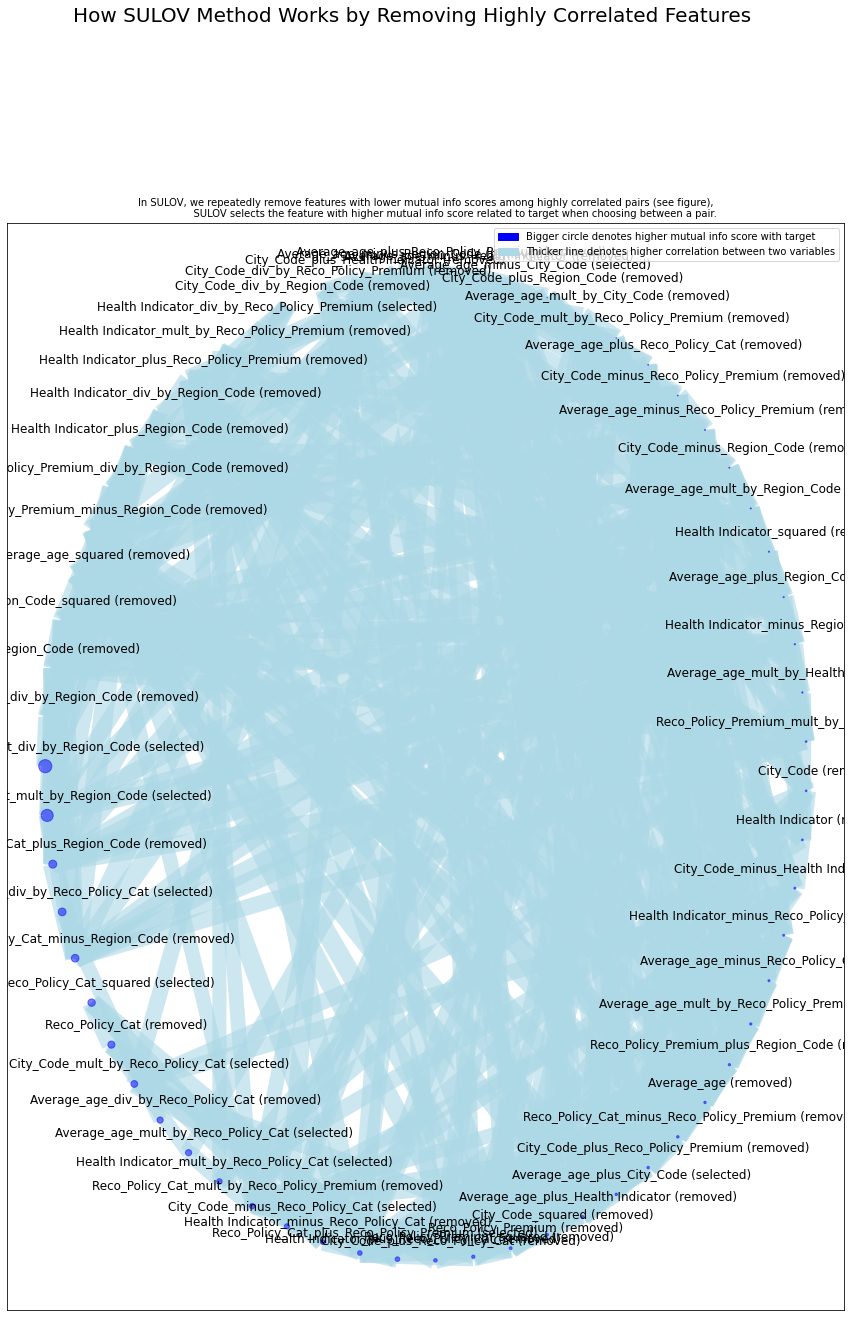

    Adding 0 categorical variables to reduced numeric variables  of 22
############## F E A T U R E   S E L E C T I O N  ####################
Current number of predictors = 22 
    Finding Important Features using Boosted Trees algorithm...
        using 22 variables...
        using 18 variables...
        using 14 variables...
        using 10 variables...
        using 6 variables...
        using 2 variables...
Selected 14 important features from your dataset
    Time taken (in seconds) = 37
Returning list of 14 important features and dataframe.
Returning 2 dataframes: train and test with 14 important features.


In [79]:
from featurewiz import featurewiz

RANDOM_SEED = 99
target = 'Response'
preds = [x for x in list(train) if x != target]

output = featurewiz(train, target, corr_limit=0.70,verbose=1, test_data=test,
                      feature_engg=["groupby",'target','interactions'], 
                     category_encoders='OneHotEncoder'
                     )

# CatBoost with Feature Engineering

In [80]:
trainm,testm= output

In [82]:
RANDOM_SEED = 101
target = 'Response'
preds = [x for x in list(trainm) if x != target]

trainm, testm = train_test_split(trainm, test_size=0.2,random_state=RANDOM_SEED)
print(trainm.shape, testm.shape)

(26051, 15) (6513, 15)


In [83]:
# number of features

cat_vars = trainm.select_dtypes(include='category').columns.tolist() + trainm.select_dtypes(include='object').columns.tolist()
trainm[cat_vars]=trainm[cat_vars].fillna(trainm.mean().iloc[0])
feats = [x for x in list(trainm) if x not in [target]]
len(feats)

14

In [84]:
feats

['Reco_Policy_Cat_squared',
 'City_Code_div_by_Reco_Policy_Cat',
 'City_Code_minus_Reco_Policy_Cat',
 'City_Code_mult_by_Reco_Policy_Cat',
 'Average_age_mult_by_Reco_Policy_Cat',
 'Health Indicator_div_by_Reco_Policy_Cat',
 'Reco_Policy_Cat_mult_by_Region_Code',
 'Health Indicator_mult_by_Reco_Policy_Cat',
 'Reco_Policy_Cat_div_by_Region_Code',
 'Reco_Policy_Premium_mult_by_Region_Code',
 'Health Indicator_div_by_Reco_Policy_Premium',
 'Reco_Policy_Cat_plus_Reco_Policy_Premium',
 'Average_age_plus_City_Code',
 'Average_age_minus_City_Code']

In [85]:
RFC = CatBoostClassifier()
RFC.fit(trainm[feats],trainm[target], metric_period=100)

Learning rate set to 0.041447
0:	learn: 0.6792004	total: 15.9ms	remaining: 15.9s
100:	learn: 0.5199773	total: 1.48s	remaining: 13.2s
200:	learn: 0.5093284	total: 2.78s	remaining: 11.1s
300:	learn: 0.4995100	total: 4.05s	remaining: 9.41s
400:	learn: 0.4893408	total: 5.36s	remaining: 8s
500:	learn: 0.4804196	total: 6.67s	remaining: 6.64s
600:	learn: 0.4720226	total: 8s	remaining: 5.31s
700:	learn: 0.4641735	total: 9.37s	remaining: 4s
800:	learn: 0.4571842	total: 10.7s	remaining: 2.66s
900:	learn: 0.4500677	total: 12.3s	remaining: 1.35s
999:	learn: 0.4434830	total: 13.8s	remaining: 0us


In [86]:
print('ROC_AUC :',round(roc_auc_score(testm[target].values, RFC.predict(testm[feats])),6))
print("Accuracy:",round(accuracy_score(testm[target].values, RFC.predict(testm[feats])),6))

ROC_AUC : 0.511345
Accuracy: 0.761247
